In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import wandb
import matplotlib.pyplot as plt
import os

In [2]:
class Conv1DModel(nn.Module):
    def __init__(self):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        return x


In [3]:
spd_data = np.load("PositiveData.npy", allow_pickle=True)
data = spd_data*100 

In [4]:
X_train, X_test = train_test_split(data.T, test_size=0.2, random_state=42)

In [5]:
X_train.shape

(4528, 400)

In [6]:
data_train = X_train.T
data_test = X_test.T

In [7]:
# Normalize the data
scaler = MinMaxScaler()
data_train = scaler.fit_transform(X_train).T
data_test = scaler.fit_transform(X_test).T

In [8]:
data_train.shape

(400, 4528)

In [9]:
# Split the data into train and test sets

# Convert the train and test data to PyTorch tensors
X_train_tensor = torch.tensor(data_train).float().unsqueeze(1)
X_test_tensor = torch.tensor(data_test).float().unsqueeze(1)


In [10]:
# Initialize the model, criterion, and optimizer
model = Conv1DModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
epochs = 50
batch_size = 32

train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)




In [11]:
model.train()
train_loss = 0.0
for epoch in range(epochs):
    for batch_idx, (batch_data,) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()

        train_loss += loss
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item()/len(train_loader):.4f}")


# Test the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, X_test_tensor)

print("Test loss:", test_loss.item())

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch [1/50], Train Loss: 0.0001
Epoch [2/50], Train Loss: 0.0000
Epoch [3/50], Train Loss: 0.0000
Epoch [4/50], Train Loss: 0.0000
Epoch [5/50], Train Loss: 0.0000
Epoch [6/50], Train Loss: 0.0000
Epoch [7/50], Train Loss: 0.0000
Epoch [8/50], Train Loss: 0.0000
Epoch [9/50], Train Loss: 0.0000
Epoch [10/50], Train Loss: 0.0000
Epoch [11/50], Train Loss: 0.0000
Epoch [12/50], Train Loss: 0.0000
Epoch [13/50], Train Loss: 0.0000
Epoch [14/50], Train Loss: 0.0000
Epoch [15/50], Train Loss: 0.0000
Epoch [16/50], Train Loss: 0.0000
Epoch [17/50], Train Loss: 0.0000
Epoch [18/50], Train Loss: 0.0000
Epoch [19/50], Train Loss: 0.0000
Epoch [20/50], Train Loss: 0.0000
Epoch [21/50], Train Loss: 0.0000
Epoch [22/50], Train Loss: 0.0000
Epoch [23/50], Train Loss: 0.0000
Epoch [24/50], Train Loss: 0.0000
Epoch [25/50], Train Loss: 0.0000
Epoch [26/50], Train Loss: 0.0000
Epoch [27/50], Train Loss: 0.0000
Epoch [28/50], Train Loss: 0.0000
Epoch [29/50], Train Loss: 0.0000
Epoch [30/50], Train Lo

In [12]:
print("Test loss:", test_loss.item()/len(X_test_tensor))

Test loss: 3.271316700192983e-08


In [13]:
#反归一化
test = torch.squeeze(test_outputs)
test.shape
testoutput = test.numpy()
test_result = scaler.inverse_transform(testoutput.T).T
test_result.shape

(400, 1133)

In [14]:
spectrum_test = X_test.T/100
#respectrum_test = test_outputs/100
respectrum_test = test_result/100 #归一化的

In [16]:
respectrum_test.shape

(400, 1133)

In [17]:
wavelengths = np.arange(380, 780, 1)

def Plot(Light, save_path=None):
    # 创建一个包含三个子图的图像
    fig, axs = plt.subplots(3, 1)
    s = spectrum_test[:, Light]
    r = respectrum_test[:, Light]

    # 绘制真实光谱图
    axs[0].plot(wavelengths, s, label='True Spectrum')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Intensity')
    axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
    axs[0].legend()

        # 绘制重建光谱图
    axs[1].plot(wavelengths, r, label='Reconstructed Spectrum')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

    # 绘制重建光谱和真实光谱叠加的图
    axs[2].plot(wavelengths, s, label='True Spectrum')
    axs[2].plot(wavelengths, r, label='Reconstructed Spectrum')
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('Intensity')
    axs[2].legend()

    if save_path:
        file_name = f"Light_s{Light + 1}.png"
        plt.savefig(os.path.join(save_path, file_name))

    plt.tight_layout()
    plt.show()

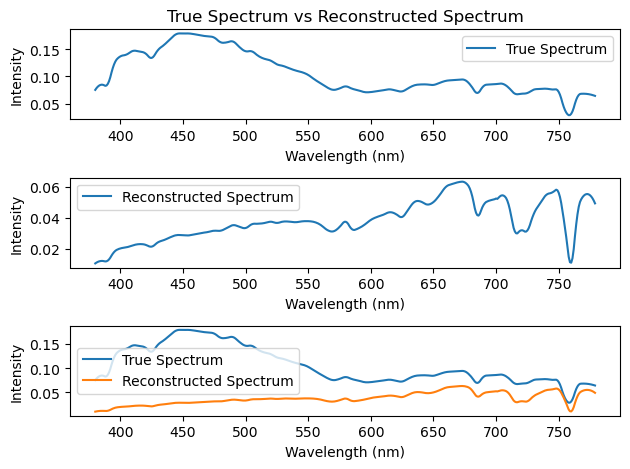

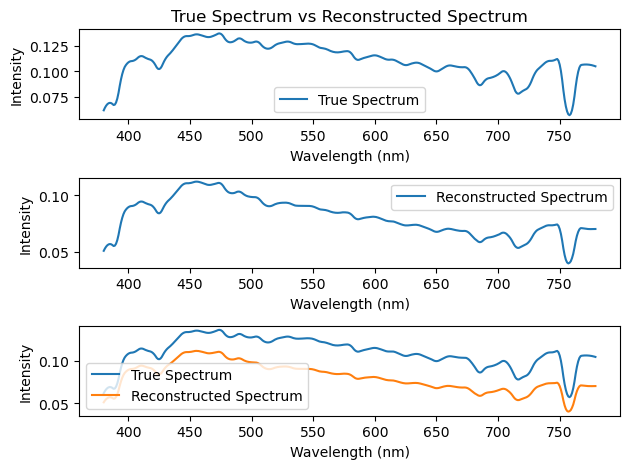

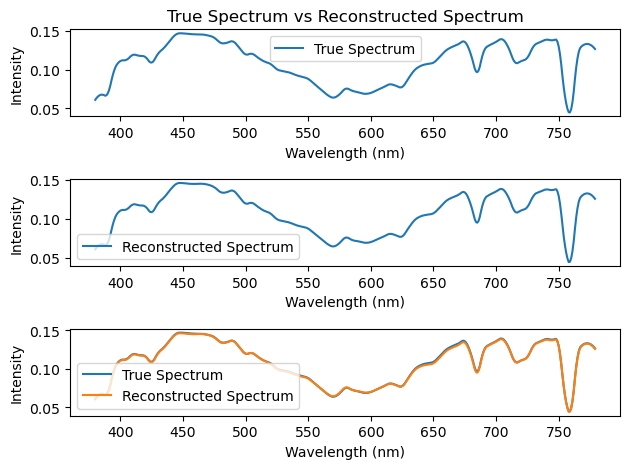

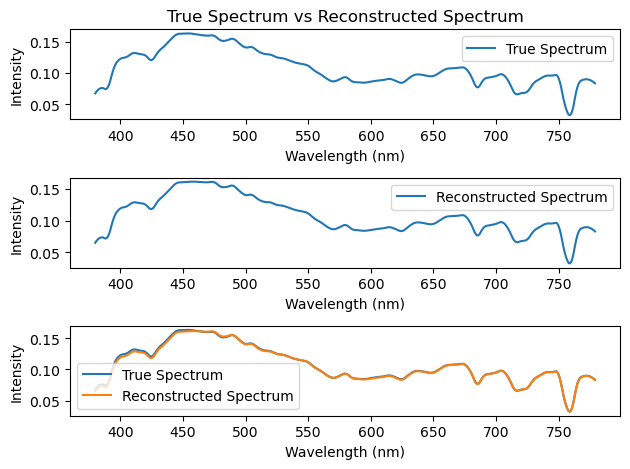

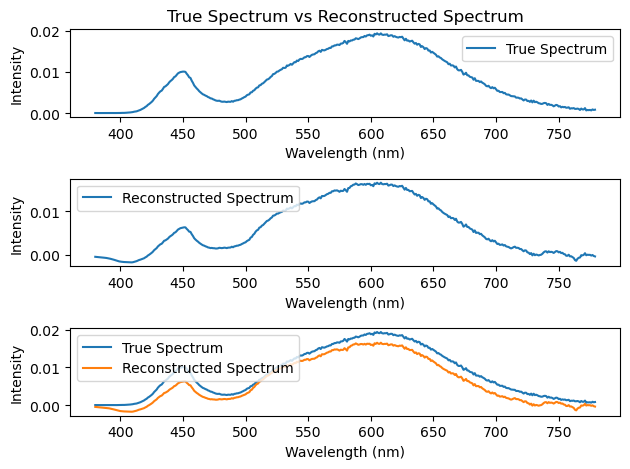

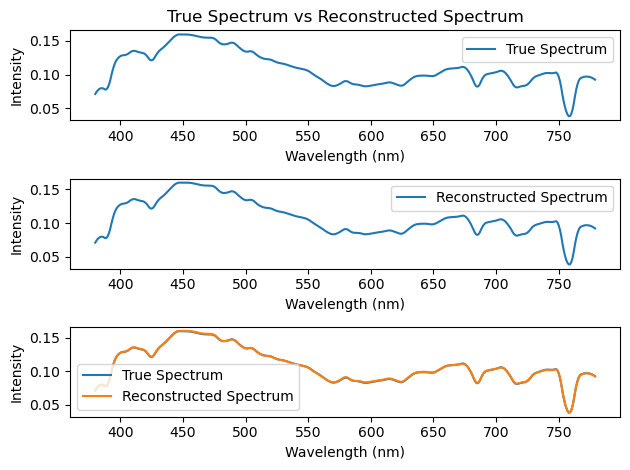

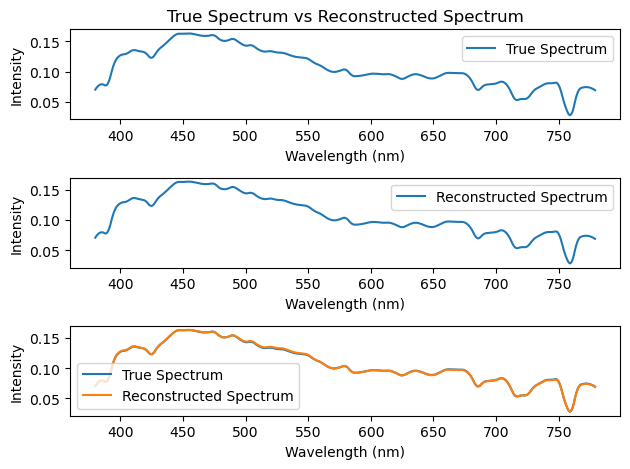

In [18]:
Light_list = [0,1,100,200,600,700,1000]

for i in Light_list:
    Plot(i, "output")


In [19]:
negative_values = np.where(respectrum_test < 0)
band_indices, sample_indices = negative_values

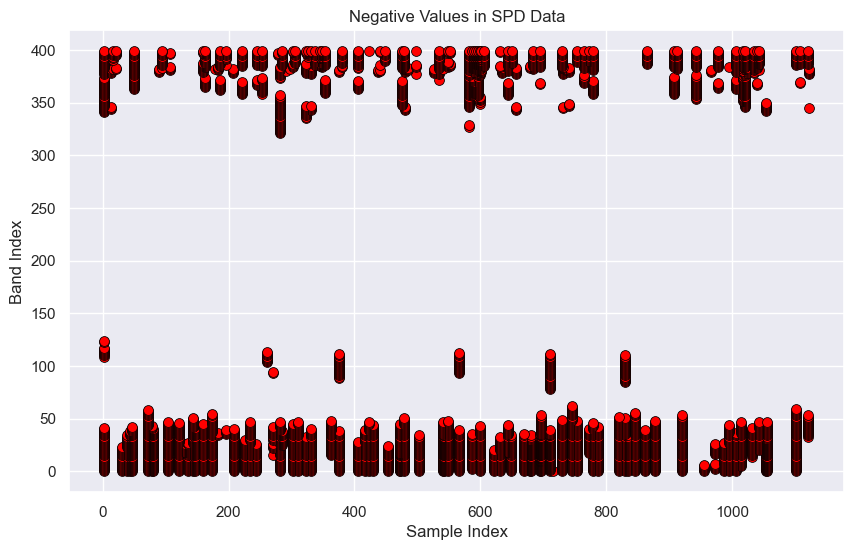

In [20]:
import seaborn as sns
import pandas as pd
sns.set_theme()
negative_values_df = pd.DataFrame({'Sample Index': sample_indices, 'Band Index': band_indices})
# 使用seaborn绘制散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=negative_values_df, x='Sample Index', y='Band Index', color='red', edgecolor='black', s=50)
plt.grid(True)
plt.title("Negative Values in SPD Data")
plt.show()